In [1]:
import pandas as pd                                       #importing pandas
import numpy as np                                        #importing numpy
import matplotlib.pyplot as plt                           #importing matplotlib 
import seaborn as sns                                     #importing seaborn
from sklearn.model_selection import train_test_split      #importing scikit-learn's function for data splitting
from sklearn.linear_model import LinearRegression         #importing scikit-learn's linear regressor function
from sklearn.neural_network import MLPRegressor           #importing scikit-learn's neural network function
from sklearn.ensemble import GradientBoostingRegressor    #importing scikit-learn's gradient booster regressor function
from sklearn.metrics import mean_squared_error            #importing scikit-learn's root mean squared error function for model evaluation
from sklearn.model_selection import cross_validate        #improting scikit-learn's cross validation function
import random
import time
from scipy.stats import ks_2samp, kruskal
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator

In [2]:
boxscores = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/fantasy_basketball/boxscores_dataset.csv')     #load boxscores dataset
# running locally
# boxscores = pd.read_csv('boxscores_dataset.csv')     #load boxscores dataset
boxscores = boxscores[(boxscores.playMin>=3) | (boxscores.playMin.isnull())]

Text(137.72222222222223, 0.5, 'Fantasy Points')

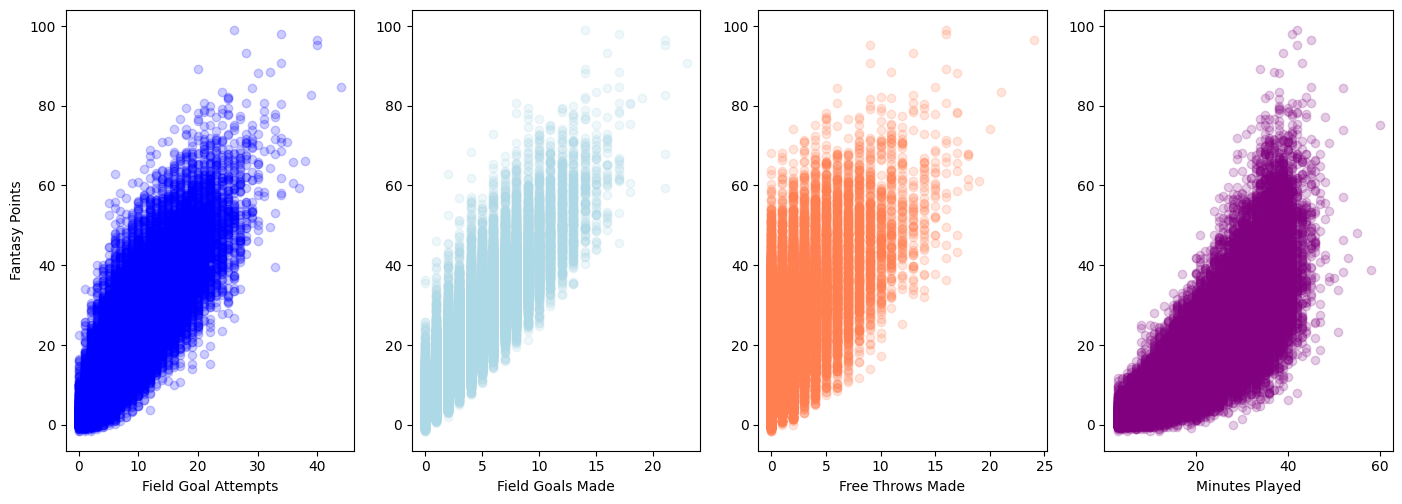

In [3]:
fig, (FGA, FGM, FTM, Min) = plt.subplots(1, 4, figsize=(14,5))
fig.tight_layout()

FGA.scatter(boxscores['playFGA'], boxscores['FantasyPoints'], c='blue', alpha = .2)
FGM.scatter(boxscores['playFGM'], boxscores['FantasyPoints'], c='lightblue', alpha = .2)
FTM.scatter(boxscores['playFTM'], boxscores['FantasyPoints'], c='coral', alpha = .2)
Min.scatter(boxscores['playMin'], boxscores['FantasyPoints'], c='purple', alpha = .2)

FGA.set_xlabel('Field Goal Attempts')
FGM.set_xlabel('Field Goals Made')
FTM.set_xlabel('Free Throws Made')
Min.set_xlabel('Minutes Played')

FGA.set_ylabel('Fantasy Points')

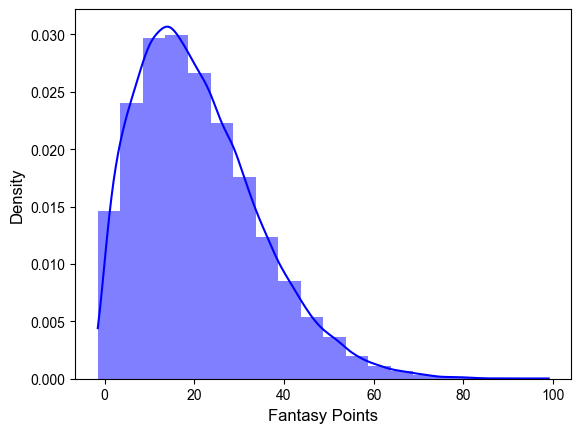

In [4]:
hplot = sns.histplot(boxscores['FantasyPoints'], color="blue", label="Fantasy Points", kde=True, stat="density", linewidth=0, bins=20)
hplot.set_xlabel("Fantasy Points", fontsize = 12)
hplot.set_ylabel("Density", fontsize = 12)
sns.set(rc={"figure.figsize":(14, 5)})

In [5]:
horizon=3

for column_name in ['playPTS','playAST','playTO','playSTL','playBLK','playTRB','playFGA','playFTA','play2P%','play3P%','playFT%','playMin','teamDayOff','FantasyPoints']:
    boxscores['moving' + column_name] = boxscores.groupby(['playDispNm'])[column_name].transform(lambda x: x.rolling(horizon, 1).mean().shift(1))
print(boxscores)

       Unnamed: 0      gmDate gmTime  seasTyp  playLNm    playFNm teamAbbr  \
0             226  2016-10-26   8:00  Regular  Abrines  Alejandro      OKC   
2            1382  2016-11-02  10:30  Regular  Abrines  Alejandro      OKC   
3            1492  2016-11-03  10:30  Regular  Abrines  Alejandro      OKC   
4            1724  2016-11-05   6:00  Regular  Abrines  Alejandro      OKC   
5            2130  2016-11-07   8:00  Regular  Abrines  Alejandro      OKC   
...           ...         ...    ...      ...      ...        ...      ...   
36752       23335  2017-03-26   9:30  Regular    Zubac      Ivica      LAL   
36753       23622  2017-03-28  10:30  Regular    Zubac      Ivica      LAL   
36756       29682  2017-11-09   7:00  Regular    Zubac      Ivica      LAL   
36758       31582  2017-11-21  10:30  Regular    Zubac      Ivica      LAL   
36760       33441  2017-12-03   9:30  Regular    Zubac      Ivica      LAL   

      teamConf    teamDiv teamLoc  ... movingplayBLK  movingpla

In [6]:
boxscores.dropna(subset = ["movingplayPTS"], inplace=True)  

In [7]:
print(boxscores)

       Unnamed: 0      gmDate gmTime  seasTyp  playLNm    playFNm teamAbbr  \
2            1382  2016-11-02  10:30  Regular  Abrines  Alejandro      OKC   
3            1492  2016-11-03  10:30  Regular  Abrines  Alejandro      OKC   
4            1724  2016-11-05   6:00  Regular  Abrines  Alejandro      OKC   
5            2130  2016-11-07   8:00  Regular  Abrines  Alejandro      OKC   
6            2447  2016-11-09   8:00  Regular  Abrines  Alejandro      OKC   
...           ...         ...    ...      ...      ...        ...      ...   
36752       23335  2017-03-26   9:30  Regular    Zubac      Ivica      LAL   
36753       23622  2017-03-28  10:30  Regular    Zubac      Ivica      LAL   
36756       29682  2017-11-09   7:00  Regular    Zubac      Ivica      LAL   
36758       31582  2017-11-21  10:30  Regular    Zubac      Ivica      LAL   
36760       33441  2017-12-03   9:30  Regular    Zubac      Ivica      LAL   

      teamConf    teamDiv teamLoc  ... movingplayBLK  movingpla

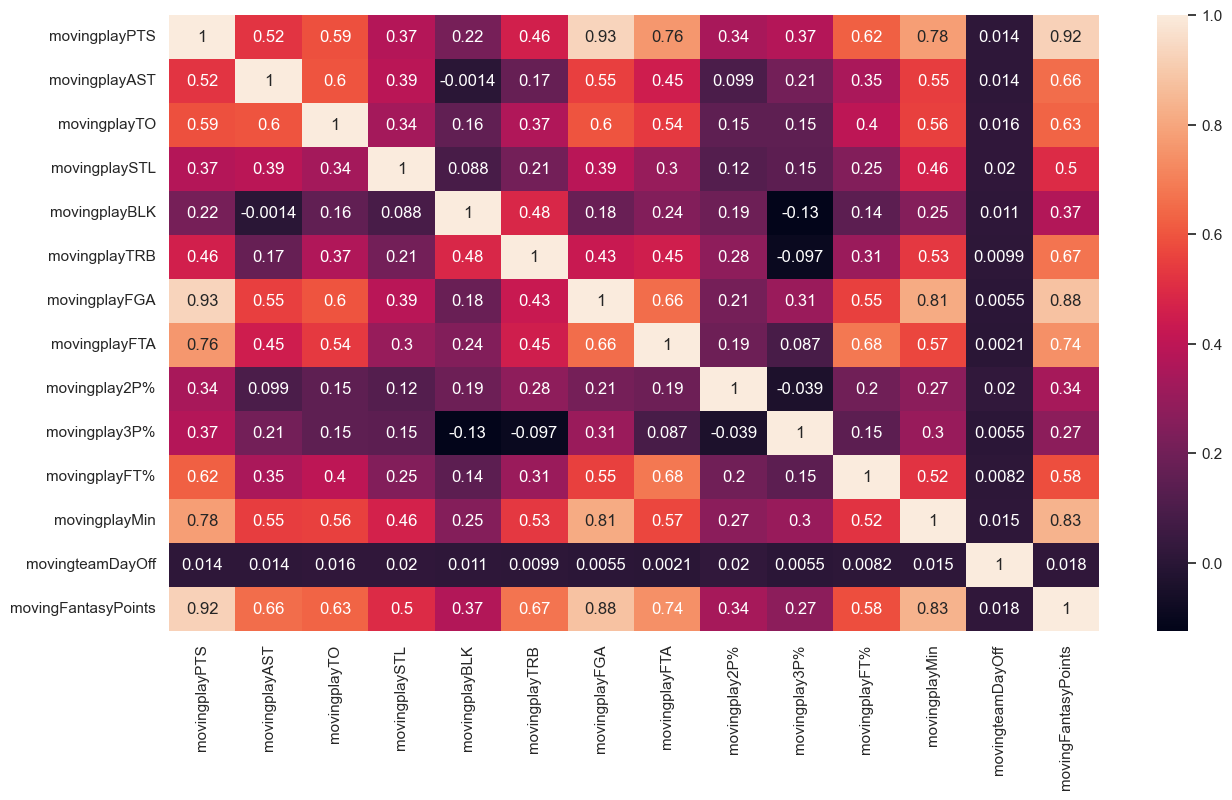

In [8]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(boxscores[['movingplayPTS', 'movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFGA','movingplayFTA','movingplay2P%','movingplay3P%','movingplayFT%','movingplayMin','movingteamDayOff','movingFantasyPoints']].corr(),annot=True)
plt.show()

In [9]:
boxscores['dummyTeamLoc'] = pd.get_dummies(data=boxscores['teamLoc'],drop_first=True)    #1 if the game is a home game, 0 if it is an away game
boxscores['dummyplayStat'] = pd.get_dummies(data=boxscores['playStat'],drop_first=True)  #1 if the player starts, 0 if the player comes from the bench

In [10]:
forecasting_data = boxscores[boxscores.gmDate != '2017-12-25']  #for model training, we exclude observation on December 25, 2017

In [11]:
X = forecasting_data[['movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFTA','movingplayFT%','dummyplayStat']]  #select the features that will be used for model training
y = forecasting_data['FantasyPoints']  #target set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)      #dataset splitting

linear_regressor = LinearRegression()                                                         #load linear regressor
linear_regressor.fit(X_train, y_train)                                                        #train the linear regression model
linear_regression_validation = cross_validate(linear_regressor, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

mlp = MLPRegressor(hidden_layer_sizes=(5,5), activation='relu')                               #load neural network
mlp.fit(X_train,y_train)                                                                      #train the neural network with a ReLU function and two hidden layers with 5 nodes each
mlp_validation = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

gb = GradientBoostingRegressor()                                                              #load a gradient boosting regressor
gb.fit(X_train, y_train)                                                                      #train a gradient boosting model
gb_validation = cross_validate(gb, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

In [12]:
gb_validation['test_score']  

array([0.50922423, 0.49918769, 0.48132471, 0.49765768, 0.50066192])

In [13]:
linear_regression_predictions = linear_regressor.predict(X_test)                              #make predictions based on the test set for the linear regression model
mlp_predictions = mlp.predict(X_test)                                                         #make predictions based on the test set for the neural network model
gb_predictions = gb.predict(X_test)                                                           #make predictions based on the test set for the gradient boosting model

linear_regression_mse = mean_squared_error(y_test, linear_regression_predictions)             #calculate the MSE for the linear regression model
mlp_mse = mean_squared_error(y_test, mlp_predictions)                                         #calculate the MSE for the neural network model
gb_mse = mean_squared_error(y_test, gb_predictions)                                           #calculate the MSE for the gradient boosting model

results = {'Linear Regression':[linear_regression_mse],'ReLU Neural Network':[mlp_mse],'Gradient Boosting Regressor':[gb_mse]}
modeling_results = pd.DataFrame(data=results,index=['MSE'])

modeling_results

,Linear Regression,ReLU Neural Network,Gradient Boosting Regressor
MSE,91.077312,90.383608,90.668092


Text(967.9632352941177, 0.5, 'Gradient Boosting Residual')

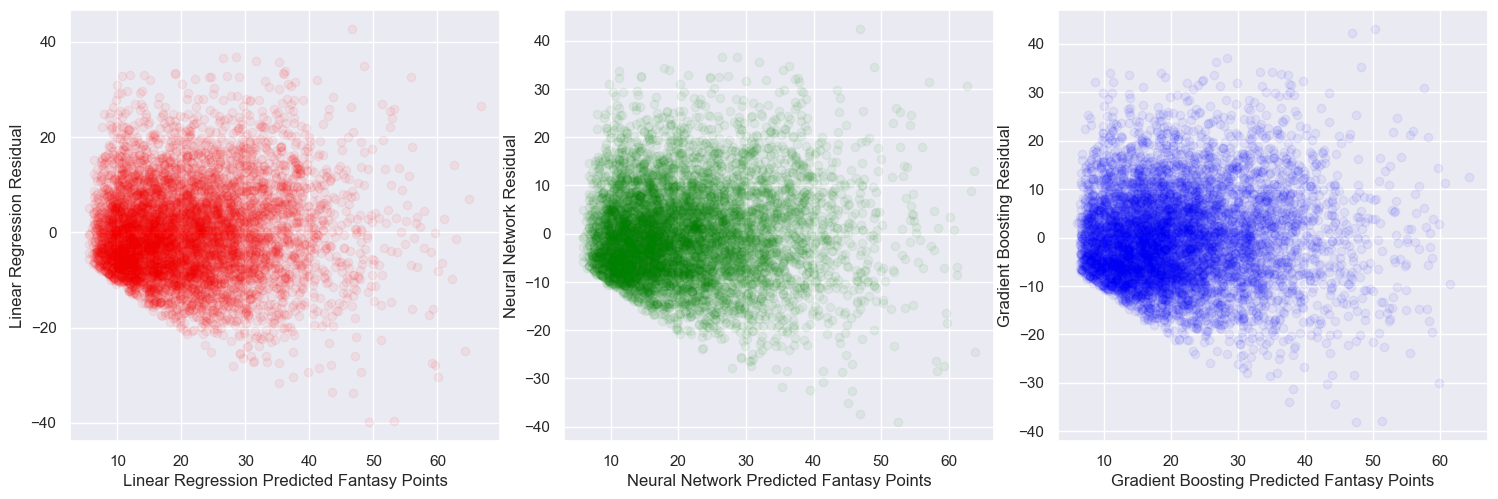

In [14]:
fig, (LR, FNN, GBR) = plt.subplots(1, 3,figsize=(15,5));
fig.tight_layout()

LR.scatter(x = linear_regression_predictions, y = y_test - linear_regression_predictions,color='red',alpha=0.06)
FNN.scatter(x = mlp_predictions, y = y_test - mlp_predictions, color='green',alpha=0.06)
GBR.scatter(x = gb_predictions, y = y_test - gb_predictions, color='blue',alpha=0.06)

LR.set_xlabel('Linear Regression Predicted Fantasy Points')
FNN.set_xlabel('Neural Network Predicted Fantasy Points')
GBR.set_xlabel('Gradient Boosting Predicted Fantasy Points')

LR.set_ylabel('Linear Regression Residual')
FNN.set_ylabel('Neural Network Residual')
GBR.set_ylabel('Gradient Boosting Residual')

In [15]:
gb_final = GradientBoostingRegressor(random_state=4)                                                             
gb_final.fit(X, y)   

optimization_dataset = boxscores
optimization_dataset['PredictedFantasyPoints'] = gb_final.predict(boxscores[['movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFTA','movingplayFT%','dummyplayStat']]) 

player_results = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/fantasy_basketball/target_games.csv')
# player_results = pd.read_csv('target_games.csv')

predicted_fantasy_points = (
    optimization_dataset.query("gmDate == '2017-12-25'")
    [["playDispNm", "PredictedFantasyPoints"]]
)

player_results = pd.merge(
    left = player_results,
    right = predicted_fantasy_points,
    left_on = "Player",
    right_on = "playDispNm",
)

In [16]:
print(player_results)

               Player Pos Team     Opp  Salary         playDispNm  \
0        James Harden  PG  HOU   @ OKC   11100       James Harden   
1        LeBron James  SF  CLE   @ GSW   11000       LeBron James   
2   Russell Westbrook  PG  OKC  vs HOU   10900  Russell Westbrook   
3        Kevin Durant  SF  GSW  vs CLE   10500       Kevin Durant   
4         Joel Embiid   C  PHI   @ NYK    9500        Joel Embiid   
..                ...  ..  ...     ...     ...                ...   
91       Andrew Bogut   C  LAL  vs MIN    3000       Andrew Bogut   
92        Alex Caruso  PG  LAL  vs MIN    3000        Alex Caruso   
93      Briante Weber  PG  HOU   @ OKC    3000      Briante Weber   
94         Cedi Osman  SG  CLE   @ GSW    3000         Cedi Osman   
95       Josh Huestis  SF  OKC  vs HOU    3000       Josh Huestis   

    PredictedFantasyPoints  
0                48.809577  
1                48.149718  
2                44.007224  
3                43.438575  
4                51.313689

In [17]:
pd.set_option('display.expand_frame_repr', False)
player_results['Points/Salary Ratio'] = 1000*player_results['PredictedFantasyPoints']/player_results['Salary']    #we multiple the fantasy vs salary ratio by 1000 for better visualization
player_results.sort_values(by='PredictedFantasyPoints',ascending=False).head(5)

,Player,Pos,Team,Opp,Salary,playDispNm,PredictedFantasyPoints,Points/Salary Ratio
4,Joel Embiid,C,PHI,@ NYK,9500,Joel Embiid,51.313689,5.401441
0,James Harden,PG,HOU,@ OKC,11100,James Harden,48.809577,4.397259
1,LeBron James,SF,CLE,@ GSW,11000,LeBron James,48.149718,4.377247
2,Russell Westbrook,PG,OKC,vs HOU,10900,Russell Westbrook,44.007224,4.037360
3,Kevin Durant,SF,GSW,vs CLE,10500,Kevin Durant,43.438575,4.137007


In [18]:
indices = player_results.Player
points = dict(zip(indices, player_results.PredictedFantasyPoints))
salaries = dict(zip(indices, player_results.Salary))
S = 30000
positions = dict(zip(indices, player_results.Pos))

In [19]:
# Lista de posiciones que deben ser cubiertas en cada equipo
posiciones = ["C", "PG", "SG", "SF", "PF"] 
# Crear un diccionario con los jugadores agrupados por posición
jugadores_por_posicion = {pos: [nombre for nombre in indices if positions[nombre] == pos] 
                          for pos in posiciones}

## Distinto al resto

## Grid search

In [20]:
# Definir el modelo de optimización
class FantasyTeamOptimizer(BaseEstimator):
    def __init__(self, points, salaries, positions, posiciones_requeridas, salario_maximo):
        self.points = points
        self.salaries = salaries
        self.positions = positions
        self.posiciones_requeridas = posiciones_requeridas
        self.salario_maximo = salario_maximo

    def fitness(self, equipo):
        # Función de fitness: calcular los puntos fantasy del equipo
        total_puntos = sum([self.points[player] for player, selected in equipo.items() if selected])
        total_salario = sum([self.salaries[player] for player, selected in equipo.items() if selected])

        # Verificar que el salario no exceda el presupuesto
        if total_salario > self.salario_maximo:
            total_puntos -= 10000  # Penalización si el salario excede el presupuesto

        return total_puntos

    def fit(self, X, y=None):
        return self

    def score(self, X, y=None):
        # Evaluar la función de fitness con la combinación de jugadores (X)
        return self.fitness(X)

In [21]:
# Crear una función para definir el espacio de búsqueda
def definir_espacio_busqueda(jugadores_por_posicion):
    # Crear un diccionario de combinaciones posibles de jugadores para cada posición
    space = {}
    for pos, jugadores in jugadores_por_posicion.items():
        space[pos] = jugadores  # Cada posición puede tomar cualquier jugador de esa posición
    
    return space

In [22]:
import itertools

# Función personalizada para realizar la búsqueda exhaustiva (grid search)
def busqueda_personalizada(jugadores_por_posicion, points, salaries, positions, salario_maximo):
    # Definir el espacio de búsqueda
    param_grid = definir_espacio_busqueda(jugadores_por_posicion)
    
    # Generar todas las combinaciones posibles de jugadores (combinación cartesianamente de todas las posiciones)
    combinaciones_posibles = list(itertools.product(*param_grid.values()))
    
    mejor_fitness = -np.inf  # Inicializamos el fitness con un valor muy bajo
    mejor_combinacion = None  # Almacenamos la mejor combinación de jugadores
    
    # Evaluar todas las combinaciones posibles
    for combinacion in combinaciones_posibles:
        equipo = dict(zip(param_grid.keys(), combinacion))  # Asignamos los jugadores a sus posiciones
        total_puntos = sum([points[jugador] for jugador in equipo.values()])  # Calcular puntos fantasy del equipo
        total_salario = sum([salaries[jugador] for jugador in equipo.values()])  # Calcular salario total
        
        # Penalizar si el salario excede el presupuesto
        if total_salario > salario_maximo:
            total_puntos -= 10000  # Penalización arbitraria
        
        # Si encontramos una combinación con mejor fitness, la actualizamos
        if total_puntos > mejor_fitness:
            mejor_fitness = total_puntos
            mejor_combinacion = equipo
    
    return mejor_combinacion, mejor_fitness, combinaciones_posibles

In [23]:
# Realizar la búsqueda personalizada (grid search)
mejor_equipo, mejor_fitness, combinaciones_posibles = busqueda_personalizada(jugadores_por_posicion, points, salaries, positions, S)

# Mostrar los resultados
print("Mejor equipo encontrado:", mejor_equipo)
print("Mejor fitness (puntos fantasy):", mejor_fitness)

Mejor equipo encontrado: {'C': 'Joel Embiid', 'PG': 'Jarrett Jack', 'SG': 'Trevor Ariza', 'SF': 'Markieff Morris', 'PF': 'Dario Saric'}
Mejor fitness (puntos fantasy): 171.91892913632242


In [24]:
len(combinaciones_posibles)

1986336

## Random search

In [54]:
import random

# Modificación de la función Random Search para usar 'param_grid'
def busqueda_random(jugadores_por_posicion, points, salaries, positions, salario_maximo, n_iter=5000):
    # Crear un espacio de búsqueda (param_grid) basado en los jugadores disponibles por posición
    param_grid = definir_espacio_busqueda(jugadores_por_posicion)
    
    mejor_fitness = -np.inf
    mejor_combinacion = None
    
    for _ in range(n_iter):
        # Seleccionar aleatoriamente un jugador de cada posición desde param_grid
        combinacion_aleatoria = {pos: random.choice(param_grid[pos]) for pos in param_grid}
        
        # Calcular puntos fantasy y salario del equipo seleccionado
        total_puntos = sum([points[jugador] for jugador in combinacion_aleatoria.values()])
        total_salario = sum([salaries[jugador] for jugador in combinacion_aleatoria.values()])
        
        # Penalizar si el salario excede el presupuesto
        if total_salario > salario_maximo:
            total_puntos -= 10000  # Penalización arbitraria
        
        # Actualizar la mejor combinación si el fitness es mayor
        if total_puntos > mejor_fitness:
            mejor_fitness = total_puntos
            mejor_combinacion = combinacion_aleatoria
    
    return mejor_combinacion, mejor_fitness

# Realizar la búsqueda aleatoria (random search)
mejor_equipo_random, mejor_fitness_random = busqueda_random(jugadores_por_posicion, points, salaries, positions, S)

# Mostrar los resultados
print("Mejor equipo encontrado por Random Search:", mejor_equipo_random)
print("Mejor fitness (puntos fantasy) por Random Search:", mejor_fitness_random)

Mejor equipo encontrado por Random Search: {'C': 'Joel Embiid', 'PG': 'Jarrett Jack', 'SG': 'Kelly Oubre Jr.', 'SF': 'Markieff Morris', 'PF': 'Dario Saric'}
Mejor fitness (puntos fantasy) por Random Search: 162.69980183387725
